In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
from matplotlib.ticker import PercentFormatter
from matplotlib.cm import ScalarMappable
from utils import *

In [2]:
t_start = 0                                     # Start day
t_end = 180                                     # End day
t_points = 500                                  # No. time points
t = np.linspace(t_start,t_end,t_points)         # Define time array
t_interval = (t_end - t_start)/(t_points-1)     # Calculate time interval

# Intranasal prophylaxis

In [3]:
# Define parameter values
q_array = np.linspace(0.01,0.05,5)
R0_array = np.linspace(1,5,100)
p = 0.9
gamma_m = 1/4.4
gamma_s = 1/4
epsilon_ss = 0.66
beta_array = R0_array*gamma_m*gamma_s/(p*gamma_s + (1-p)*gamma_m)
beta_m = beta_array
beta_m2 = beta_array
beta_s = beta_array
beta_s2 = beta_array
a = 1/2
c = 0.75
N = 1e5
I_m0 = 1
I_s0 = 0

# Vaccination

In [4]:
# Define parameter values
q_active = 0.01
q_v1 = 1/21
q_v2 = 1/21
beta_m = beta_array
beta_v1m = beta_array
beta_v2m = beta_array
beta_s = beta_array
beta_v1s = beta_array
beta_v2s = beta_array
gamma_m = 1/4.4
gamma_s = 1/4
epsilon_1 = 0.2*0.66
epsilon_2 = 0.66
c = 0.75

In [5]:
# Initialise results arrays
end_averted_passive = np.zeros(shape=(len(beta_array), len(q_array)))
end_averted_active = np.zeros(shape=(len(beta_array), len(q_array)))

In [6]:
# Define initial conditions
y0_passive = [N-(I_m0 + I_s0), 0, 0, I_m0, I_s0, 0]
y0_active = [N-1, 0, 0, 0, 0, I_m0, I_s0, 0]

for i, beta in enumerate(beta_array):
    for j, q in enumerate(q_array):
        # Define parameter values
        k_passive = [q, beta, beta, beta, beta, gamma_m, gamma_s, epsilon_ss, c, a, p, N]
        k_none = [0, beta, beta, beta, beta, gamma_m, gamma_s, epsilon_ss, c, a, p, N]
        k_active = [q, q_v1, q_v2, beta, beta, beta, beta, beta, beta, gamma_m, gamma_s, epsilon_1, epsilon_2, c, a, p, N]

        # Solve ODEs
        y_passive = odeint(passive_model, y0_passive, t, args=(k_passive,))
        y_none = odeint(passive_model, y0_passive, t, args=(k_none,))
        y_active = odeint(active_model, y0_active, t, args=(k_active,))

        # Calculate cumulative number of infections in each scenario
        cumul_infections_passive = np.cumsum(a*y_passive[:,2]*t_interval)
        cumul_infections_active = np.cumsum(a*y_active[:,4]*t_interval)
        cumul_infections_none = np.cumsum(a*y_none[:,2]*t_interval)

        # Calculate percentage of infections averted in each scenario
        n_averted_passive = 1 - (cumul_infections_passive)/(cumul_infections_none)
        n_averted_active = 1 - (cumul_infections_active)/(cumul_infections_none)

        # Append to array
        end_averted_passive[i,j] = n_averted_passive[-1]
        end_averted_active[i,j] = n_averted_active[-1]

/var/folders/43/ll9hmb7s3hl062ybcfj94br80000gn/T/ipykernel_19473/1661852530.py:19: RuntimeWarning: invalid value encountered in divide
  n_averted_passive = 1 - (cumul_infections_passive)/(cumul_infections_none)
/var/folders/43/ll9hmb7s3hl062ybcfj94br80000gn/T/ipykernel_19473/1661852530.py:20: RuntimeWarning: invalid value encountered in divide
  n_averted_active = 1 - (cumul_infections_active)/(cumul_infections_none)


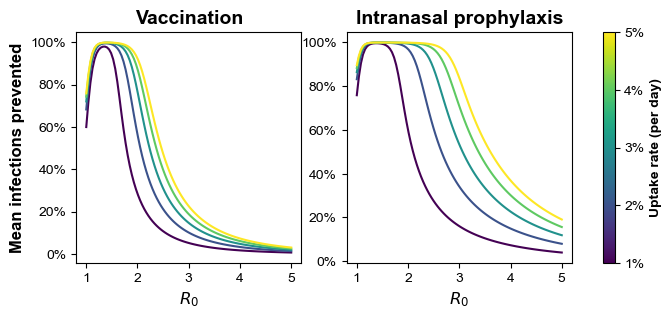

In [13]:
# Get the 'viridis' colormap
cmap = plt.cm.viridis
colors = [cmap(value) for value in np.linspace(0, 1, len(q_array))]

# Setup figure
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Create a Normalize object for mapping scalar values to [0, 1]
norm = Normalize(vmin=min(q_array), vmax=max(q_array))

# Plotting for the first subplot
for i in range(len(q_array)):
    axes[0].plot(R0_array, end_averted_active[:, i], color=colors[i])
    axes[1].plot(R0_array, end_averted_passive[:, i], color=colors[i])

# Set labels and formatting for axes[0]
axes[0].set_ylabel('Mean infections prevented', fontsize=12, weight='bold')
axes[0].set_xlabel('$R_0$', fontsize=12, weight='bold')
axes[0].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axes[0].set_title('Vaccination', fontsize=14, weight='bold')

# Set labels and formatting for axes[1]
axes[1].set_xlabel('$R_0$', fontsize=12, weight='bold')
axes[1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axes[1].set_title('Intranasal prophylaxis', fontsize=14, weight='bold')

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical')
cbar.set_label('Uptake rate (per day)', fontsize=10, weight='bold')
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))  # Set colorbar labels to percentage
cbar.set_ticks(np.linspace(min(q_array), max(q_array), len(q_array)))

# Display the plot
plt.show()

In [9]:
# Calculate the minimum and maximum percentage of infections averted for a given R0 value

R0_value = 2
index = np.argmin(np.abs(R0_array - R0_value))
values_active = end_averted_active[index]
values_passive = end_averted_passive[index]
print('Vaccination: ',np.min(values_active),'-',np.max(values_active))
print('Prophylaxis: ',np.min(values_passive),'-',np.max(values_passive))

Vaccination:  0.27842527980543397 - 0.9174041745118054
Prophylaxis:  0.5884420448911378 - 0.9989549815228428


In [15]:
fig.savefig("../figures/Figure3.svg", bbox_inches=0)